In [1]:
import pandas as pd
import datetime as dt
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt 
import functools
from tqdm import tqdm
import seaborn as sns
import quandl
import math
import statsmodels.regression.linear_model as linreg
import requests
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.regression.linear_model as linreg
# Suppress the warning
warnings.filterwarnings("ignore")
@functools.lru_cache()
def fetch_quandl_table(table, begin_date = None, end_date = None):
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      # qopts = {"columns":["date", "adj_close"]},
                      # ticker = ticker,
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      paginate=True)
    return qdata

@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None, api_key = 'bXgDCzJUfS5ZxasswLcN'):
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      api_key= api_key,
                      paginate=True)
    return qdata

@functools.lru_cache()
def fetch_options_price(option, date = '2014-01-01', end_date = '2022-12-31'):
    data_url = f'https://api.polygon.io/v1/open-close/{option}/{date}?adjusted=true&apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = f'https://api.polygon.io/v3/snapshot/options/{ticker}?apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = data_url + f'&expiration_data.gte={begin_date}'
    # data_url = data_url + f'&expiration_data.lte={end_date}'
    response = requests.get(data_url)
    if response.status_code == 200:
        return response.json()
    else:
        return response.status_code

# Get VIX close (this will be Y in our regression)

VIX_data = pd.read_csv('/Users/tmac/Downloads/VIX_History.csv')
VIX_data['DATE'] = pd.to_datetime(VIX_data['DATE'])
VIX_data = VIX_data[VIX_data['DATE'] > '2013-12-31'].set_index('DATE').drop(columns=['OPEN', 'HIGH', 'LOW']).rename(columns={'CLOSE': 'VIX'})
VIX_data = VIX_data[VIX_data.index < '2023-01-01']

# Grab (and filter) event data from FxStreet

event_data = pd.read_csv('/Users/tmac/Downloads/Economic Events.csv')
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

# Set event column to True if there's an event, False otherwise

idx = pd.date_range('2014-01-01', '2022-12-31')
VIX_data = VIX_data.reindex(idx, fill_value=None)
VIX_data['Event'] = np.where(VIX_data.index.isin(event_data.index.values), True, False)
VIX_data['Days until Event'] = np.where(VIX_data['Event'] == True, 0, VIX_data.groupby((VIX_data['Event'] == True).cumsum()).cumcount(ascending=False)+1)


# TODO: do we want weekends? remove this if so, and change fill_value above to .ffill()
VIX_data = VIX_data.dropna(subset=['VIX'])

# Grab the VIX data and shift it for regression purposes

VIX_data['VIX Shifted'] = VIX_data['VIX'].shift(1)

# Consumer Sentiment (University of Michigan Consumer Survey, Index of Consumer Sentiment)
# https://data.nasdaq.com/data/UMICH/SOC1-university-of-michigan-consumer-surveyindex-of-consumer-sentiment
# NOTE: this is monthly data, so I forward filled
consumer_sentiment_data = fetch_quandl('UMICH/SOC1', begin_date='2013-12-01', end_date='2022-12-31')
VIX_data['Consumer Sentiment Index'] = consumer_sentiment_data
VIX_data['Consumer Sentiment Index'] = VIX_data['Consumer Sentiment Index'].fillna(method='ffill')
# Fill in the first month with Dec 2013 Index value
VIX_data['Consumer Sentiment Index'] = VIX_data['Consumer Sentiment Index'].fillna(value=consumer_sentiment_data.iloc[0].Index)

# # Fetch Options chain for each expiry day
# options = ['O:SPY221215P00400000', 'O:SPY221215P00350000', 'O:SPY221216P00400000', 'O:SPY221216P00350000']
# dates = pd.date_range('2022-12-01', '2022-12-15')
# dates = [date.strftime('%Y-%m-%d') for date in dates]
# options_price_data = pd.DataFrame(index=pd.date_range('2014-01-01', '2022-12-31'), columns=options)
# for option in options:
#     for date in dates:
#         result = fetch_options_price(option, date=date)
#         if not isinstance(result, int):
#             options_price_data.loc[date, option] = result['close']



In [2]:
vix_r = VIX_data[['VIX']].pct_change()

In [3]:
shanghai = pd.read_csv('/Users/tmac/Downloads/shanghai.csv')
shanghai['Date'] = pd.to_datetime(shanghai['Date'])
shanghai = shanghai.set_index('Date')
shanghai = shanghai[['Change %']]
shanghai['Change %'] = pd.to_numeric(shanghai['Change %'].str.rstrip("%"))

In [4]:
securities = ['OWF/NYM_CL_CL']
dates = ['H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020', 'M2020', 'U2020', 'Z2020',
         'H2021', 'M2021', 'U2021', 'Z2021', 
         'H2022', 'M2022', 'U2022', 'Z2022']

# Fetch NYM_RB_RB Data
finalized_data = pd.DataFrame()
security = securities[0]
trim_start = "2014-01-01"
trim_end = "2022-12-31"
for month in tqdm(dates):
  data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
  # data = clean_quandl_columns(data)
  # data = data[data['DtT'] > 30]
  if finalized_data.empty:
    finalized_data = data
  else:
    finalized_data = finalized_data.append(data)
  trim_start = finalized_data.index[-1] + pd.DateOffset(1)

crude_oil_data = finalized_data.copy()

100%|██████████| 36/36 [00:13<00:00,  2.71it/s]


In [5]:
oil_futures = crude_oil_data[['Future']].pct_change()

In [6]:
spy =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'SPY', api_key = 'uoxc6V3s61czWuHoGLcs',
                    qopts = { 'columns': ['date', 'adj_close', 'volume'] }, 
                    date = { 'gte': '2014-01-01', 'lte': '2023-01-01' }, 
                     paginate=True)

spy.index = spy['date']

In [7]:
model_data = pd.merge(vix_r, VIX_data[['Days until Event']],  left_index=True, right_index=True)
model_data = pd.merge(model_data, spy, left_index=True, right_index=True)
model_data = pd.merge(model_data, shanghai, left_index=True, right_index=True)
model_data = pd.merge(model_data, oil_futures, left_index=True, right_index=True)

In [8]:
model_data = model_data[['VIX', 'Days until Event', 'adj_close', 'volume', 'Change %', 'Future']]
model_data = model_data.rename(columns = {'adj_close': 'Spy close', 'volume': 'Spy Volume'})


In [9]:
model_data['Spy return'] = model_data['Spy close'].pct_change()
model_data = model_data.dropna()
model_data['Change %']*=1/100


In [10]:
model_data

,VIX,Days until Event,Spy close,Spy Volume,Change %,Future,Spy return
2014-01-03,-0.033029,0,154.843559,81390600.0,-0.0124,-0.015478,-0.000164
2014-01-06,-0.015262,0,154.394837,108028200.0,-0.0180,-0.005949,-0.002898
2014-01-07,-0.046494,1,155.343079,86144200.0,0.0008,0.002778,0.006142
2014-01-08,-0.003870,0,155.376951,96582300.0,-0.0015,-0.013960,0.000218
2014-01-09,0.001554,1,155.478545,90683400.0,-0.0082,-0.006917,0.000654
...,...,...,...,...,...,...,...
2022-11-09,0.021535,1,372.399514,78294884.0,-0.0053,-0.034642,-0.020602
2022-11-10,-0.098122,0,392.864416,141120451.0,-0.0039,0.007457,0.054954
2022-11-11,-0.042924,12,396.666747,93751116.0,0.0169,0.028796,0.009678
2022-11-14,0.053730,9,393.292427,71854837.0,-0.0013,-0.034735,-0.008507


In [11]:
y = model_data[['VIX']]
exog = model_data[['Days until Event', 'Spy Volume', 'Change %', 'Future', 'Spy return']]

In [68]:
# initial = 0
# for p in tqdm(range(1,5)):
#     for d in range(1,2):
#         for q in range(1,5):           
#             x = pd.DataFrame(index = y.iloc[-200:].index, columns = ['prediction'])
#             for i in (range(1,200)):
#                 ARIMAmodel = ARIMA(y.iloc[:-i], order = (p,d,q), exog = exog.iloc[:-i]).fit()
#                 forecast = ARIMAmodel.forecast(1, exog = exog.iloc[-i])
#                 x.iloc[-i]['prediction'] = forecast.iloc[0]
#             x = x.shift(-1)
#             x['sign_pred'] = np.sign(x['prediction'].dropna())
#             x = x.dropna()
#             real = y.iloc[-199:]
#             real['sign_real'] = np.sign(real['VIX'])
#             n = pd.merge(x, real, left_index = True, right_index = True)
#             big = n[n['VIX'] > .05]
#             accuracy = len(big[(big['sign_pred'] == big['sign_real'])])/len(big)
#             if accuracy > initial:
#                 optimal = [p,d,q]
#                 optimal_accuracy = accuracy
#                 initial = accuracy
#optimal = 4,1,1

In [69]:
x = pd.DataFrame(index = y.iloc[-365:].index, columns = ['prediction'])
for i in tqdm(range(1,365)):
    ARIMAmodel = ARIMA(y.iloc[:-i], order = (4,1,1), exog = exog.iloc[:-i]).fit()
    forecast = ARIMAmodel.forecast(1, exog = exog.iloc[-i])
    x.iloc[-i]['prediction'] = forecast.iloc[0]
x = x.shift(-1)

100%|██████████| 364/364 [04:07<00:00,  1.47it/s]


In [72]:
x['sign_pred'] = np.sign(x['prediction'].dropna())
x = x.dropna()
real = y.iloc[-364:]
real['sign_real'] = np.sign(real['VIX'])
n = pd.merge(x, real, left_index = True, right_index = True)
big = n[abs(n['VIX']) > .05]
len(big[(big['sign_pred'] == big['sign_real'])])/len(big)

0.62

Text(0, 0.5, 'VIX return')

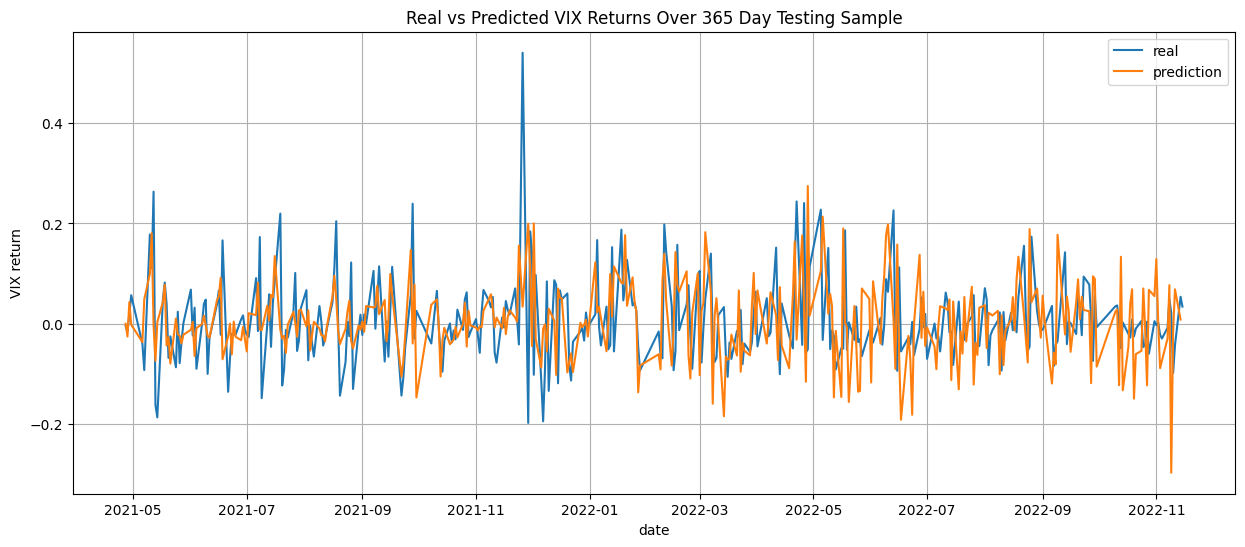

In [75]:
plt.figure(figsize = (15,6))
plt.plot(y.iloc[-365:], label = 'real')
plt.plot(x[['prediction']], label = 'prediction')
plt.grid()
plt.title('Real vs Predicted VIX Returns Over 365 Day Testing Sample')
plt.legend()
plt.xlabel('date')
plt.ylabel('VIX return')

<Figure size 1500x600 with 0 Axes>

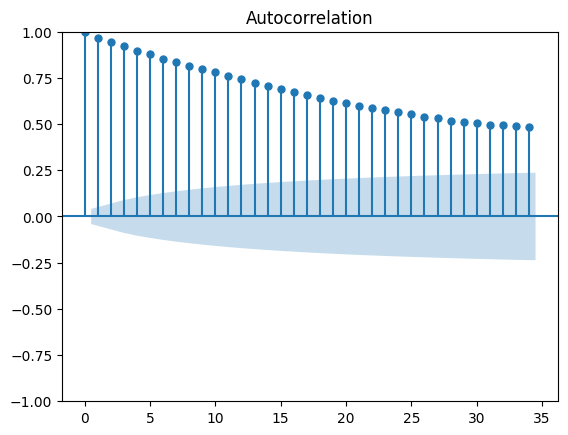

<Figure size 1500x600 with 0 Axes>

In [ ]:
plot_acf(VIX_data[['VIX']])
plt.figure(figsize = (15,6))

<Figure size 1500x600 with 0 Axes>

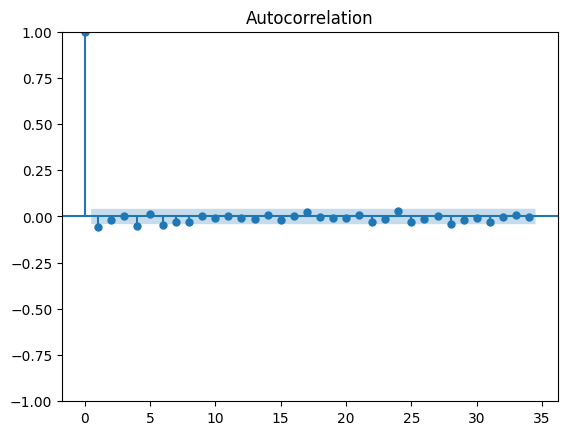

<Figure size 1500x600 with 0 Axes>

In [ ]:
plot_acf(model_data[['VIX']])
plt.figure(figsize = (15,6))

<AxesSubplot: >

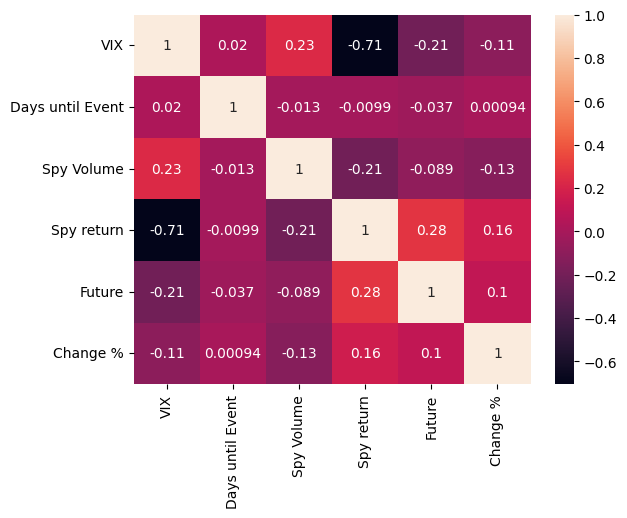

In [ ]:
sns.heatmap(model_data[['VIX','Days until Event' ,'Spy Volume', 'Spy return', 'Future', 'Change %']].corr(), annot=True)